# MANUAL METHOD

## MACD STRATEGY 

In [2]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

In [4]:
ticker = 'SBIN.NS'
start_date = '2017-11-01'
end_date = '2023-11-01'

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
df.drop(df.columns[0],axis=1,inplace=True)
df.columns = [x.lower() for x in df.columns]

[*********************100%***********************]  1 of 1 completed


In [5]:
df=df[507:]
df

,high,low,close,volume
Date,,,,
2019-11-27,330.701289,319.695458,328.787231,33971305
2019-11-28,335.917061,329.696374,334.290100,42538227
2019-11-29,333.859479,325.963992,327.160278,23081823
2019-12-02,329.552848,321.753069,323.954224,20648850
2019-12-03,328.213007,319.025526,321.800903,26482178
...,...,...,...,...
2023-10-25,560.799988,553.599976,556.200012,12134624
2023-10-26,552.900024,543.200012,547.000000,19424825
2023-10-27,562.500000,550.000000,561.150024,10415296


In [6]:
def get_macd(price,slow,fast,smooth):
    exp1 = price.ewm(span=fast,adjust=False).mean()
    exp2 = price.ewm(span=slow,adjust=False).mean()
    macd = pd.DataFrame(exp1-exp2).rename(columns={'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span=smooth,adjust=False).mean()).rename(columns={'macd':'signal'})
    hist = pd.DataFrame(macd['macd']-signal['signal']).rename(columns={0:'hist'})
    frames = [macd,signal,hist]
    df = pd.concat(frames,join='inner',axis=1)
    return df

aapl_macd = get_macd(df['close'],26,12,9)
aapl_macd.tail()

,macd,signal,hist
Date,,,
2023-10-25,-7.278439,-3.389519,-3.888920
2023-10-26,-8.705621,-4.452739,-4.252882
2023-10-27,-8.595797,-5.281351,-3.314447
2023-10-30,-8.088720,-5.842825,-2.245895
2023-10-31,-7.571339,-6.188527,-1.382811


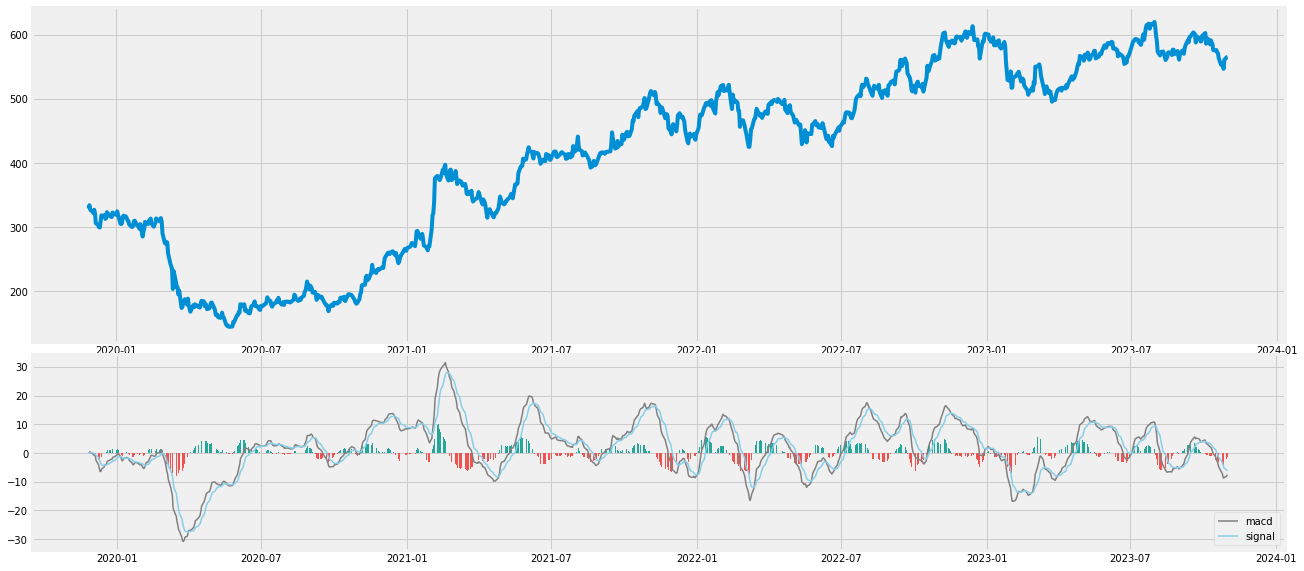

In [7]:
def plot_macd(prices,macd,signal,hist):
    plt.figure(figsize=(20,10))
    ax1 = plt.subplot2grid((8,1),(0,0),rowspan=5,colspan=1)
    ax2 = plt.subplot2grid((8,1),(5,0),rowspan=3,colspan=1)
    
    ax1.plot(prices)
    ax2.plot(macd,color='grey',linewidth=1.5,label='macd')
    ax2.plot(signal,color='skyblue',linewidth=1.5,label='signal')
    
    for i in range(len(prices)):
        if str(hist.iat[i])[0]=='-':
            ax2.bar(prices.index[i],hist.iat[i],color='#ef5350')
        else:
            ax2.bar(prices.index[i],hist.iat[i],color='#26a69a')
            
    plt.legend(loc='lower right')
    

plot_macd(df['close'],aapl_macd['macd'],aapl_macd['signal'],aapl_macd['hist'])

In [8]:
def strategy(prices,data):
    buy,sell,macd_signal,signal = [],[],[],0
    
    for i in range(len(data)):
        if data['macd'].iat[i] > data['signal'].iat[i]:
            if signal != 1:
                buy.append(prices.iat[i])
                sell.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy.append(np.nan)
                sell.append(np.nan)
                macd_signal.append(0)
        elif data['macd'].iat[i] < data['signal'].iat[i]:
            if signal != -1:
                buy.append(np.nan)
                sell.append(prices.iat[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy.append(np.nan)
                sell.append(np.nan)
                macd_signal.append(0)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            macd_signal.append(0)
                
    return buy,sell,macd_signal

buy,sell,macd_signal = strategy(df['close'],aapl_macd)

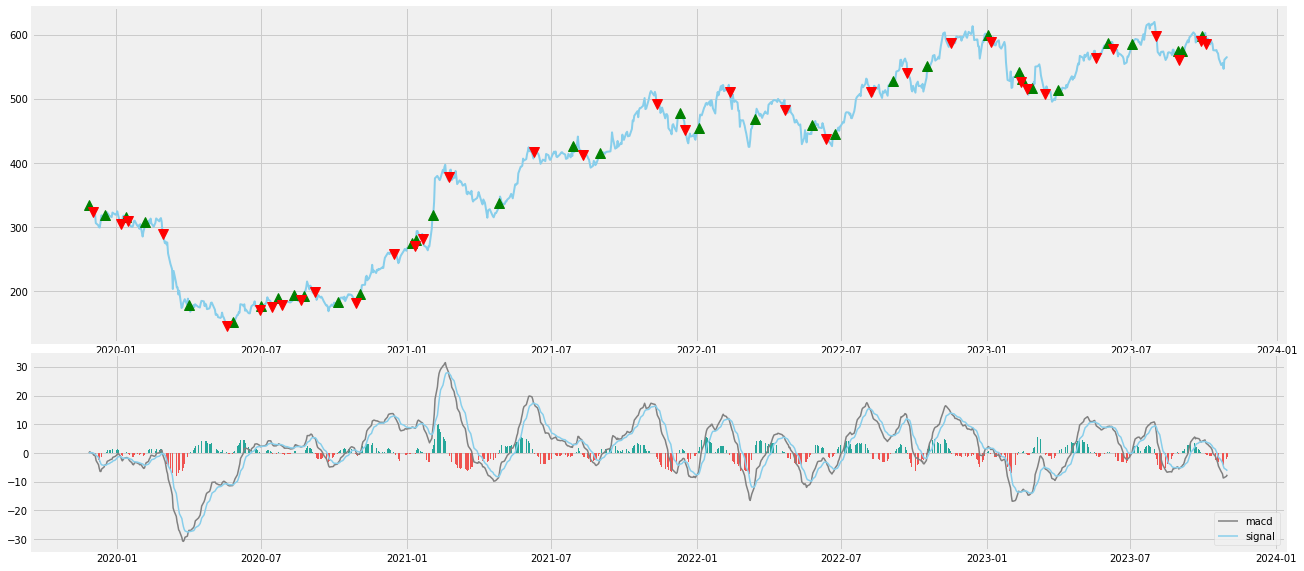

In [9]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((8,1),(0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((8,1),(5,0),rowspan=3,colspan=1)
ax1.plot(df['close'],color='skyblue',linewidth=2,label='AAPL')
ax1.plot(df.index,buy,marker='^',color='green',markersize=10,label='BUY',linewidth=0)
ax1.plot(df.index,sell,marker='v',color='red',markersize=10,label='SELL',linewidth=0)
#ax1.plot(prices)
ax2.plot(aapl_macd['macd'],color='grey',linewidth=1.5,label='macd')
ax2.plot(aapl_macd['signal'],color='skyblue',linewidth=1.5,label='signal')
    
for i in range(len(df['close'])):
    if str(aapl_macd['hist'].iat[i])[0]=='-':
        ax2.bar(df['close'].index[i],aapl_macd['hist'].iat[i],color='#ef5350')
    else:
        ax2.bar(df['close'].index[i],aapl_macd['hist'].iat[i],color='#26a69a')
            
plt.legend(loc='lower right')

In [10]:
position = []

for i in range(len(macd_signal)):
    if macd_signal[i]>1:
        position.append(0)
    else:
        position.append(1)

for i in range(len(df['close'])):
    if macd_signal[i] ==1:
        position[i] =1
    
    elif macd_signal[i] == -1:
        position[i] = 0
    
    else:
        position[i] = position[i-1]
        

macd = aapl_macd['macd']
signal = aapl_macd['signal']
close_price = df['close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns={0:'macd_position'}).set_index(df.index)

frames = [close_price,macd,signal,macd_signal,position]

strategy = pd.concat(frames,join='inner',axis=1)

strategy

,close,macd,signal,macd_signal,macd_position
Date,,,,,
2019-11-27,328.787231,0.000000,0.000000,0,1
2019-11-28,334.290100,0.438975,0.087795,1,1
2019-11-29,327.160278,0.209138,0.112064,0,1
2019-12-02,323.954224,-0.229070,0.043837,-1,0
2019-12-03,321.800903,-0.741560,-0.113242,0,0
...,...,...,...,...,...
2023-10-25,556.200012,-7.278439,-3.389519,0,0
2023-10-26,547.000000,-8.705621,-4.452739,0,0
2023-10-27,561.150024,-8.595797,-5.281351,0,0


In [11]:
aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns={0:'returns'})
macd_strat_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'].iat[i]*strategy['macd_position'].iat[i]
        macd_strat_ret.append(returns)
    except:
        pass
    
macd_ret_df = pd.DataFrame(macd_strat_ret).rename(columns = {0:'macd_returns'})

investment = 1000000

num_of_stocks = floor(investment/df['close'].iat[0])

macd_invest_ret = []

for i in range(len(macd_ret_df['macd_returns'])):
    returns = num_of_stocks * macd_ret_df['macd_returns'][i]
    macd_invest_ret.append(returns)
    
    
macd_invest_ret_df = pd.DataFrame(macd_invest_ret).rename(columns={0:'invest_returns'})
tot_invest_ret = round(sum(macd_invest_ret_df['invest_returns']),2)
profit_percentage = floor((tot_invest_ret/investment)*100)

print(cl('Profit Gained from MACD by investing $1M in AAPL : {}'.format(tot_invest_ret),attrs = ['bold']))
print(cl('Profit percentage of MACD strategy : {}%'.format(profit_percentage),attrs = ['bold']))

Profit Gained from MACD by investing $1M in AAPL : 958746.01
Profit percentage of MACD strategy : 95%


## STOCHASTIC OSCILLATOR + MACD

In [12]:
df

,high,low,close,volume
Date,,,,
2019-11-27,330.701289,319.695458,328.787231,33971305
2019-11-28,335.917061,329.696374,334.290100,42538227
2019-11-29,333.859479,325.963992,327.160278,23081823
2019-12-02,329.552848,321.753069,323.954224,20648850
2019-12-03,328.213007,319.025526,321.800903,26482178
...,...,...,...,...
2023-10-25,560.799988,553.599976,556.200012,12134624
2023-10-26,552.900024,543.200012,547.000000,19424825
2023-10-27,562.500000,550.000000,561.150024,10415296


In [13]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [14]:
ticker = 'SBIN.NS'
start_date = '2017-11-01'
end_date = '2023-11-01'

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
df.drop(df.columns[0],axis=1,inplace=True)
df.columns = [x.lower() for x in df.columns]
df=df[507:]

[*********************100%***********************]  1 of 1 completed


In [15]:
def get_stoch_osc(high, low, close, k_lookback, d_lookback):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

df['%k'], df['%d'] = get_stoch_osc(df['high'], df['low'], df['close'], 14, 3)
df

/var/folders/wn/7t0ypjsd5dxf316dyk7snjph0000gn/T/ipykernel_39172/3965985956.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['%k'], df['%d'] = get_stoch_osc(df['high'], df['low'], df['close'], 14, 3)
/var/folders/wn/7t0ypjsd5dxf316dyk7snjph0000gn/T/ipykernel_39172/3965985956.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['%k'], df['%d'] = get_stoch_osc(df['high'], df['low'], df['close'], 14, 3)


,high,low,close,volume,%k,%d
Date,,,,,,
2019-11-27,330.701289,319.695458,328.787231,33971305,NaN,NaN
2019-11-28,335.917091,329.696404,334.290131,42538227,NaN,NaN
2019-11-29,333.859479,325.963992,327.160278,23081823,NaN,NaN
2019-12-02,329.552816,321.753039,323.954193,20648850,NaN,NaN
2019-12-03,328.212976,319.025496,321.800873,26482178,NaN,NaN
...,...,...,...,...,...,...
2023-10-25,560.799988,553.599976,556.200012,12134624,10.844653,5.708166
2023-10-26,552.900024,543.200012,547.000000,19424825,6.816122,7.201392
2023-10-27,562.500000,550.000000,561.150024,10415296,33.364343,17.008372


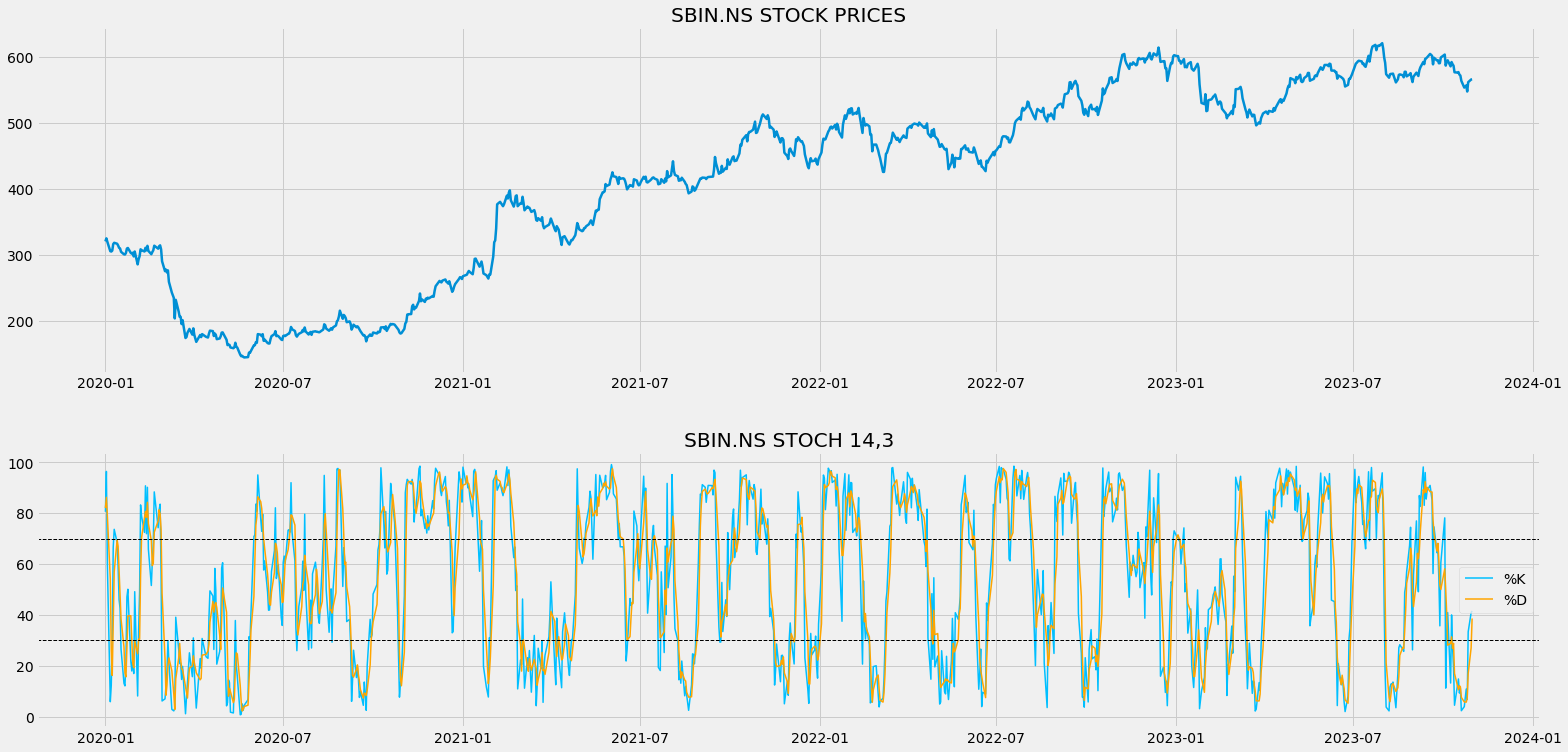

In [16]:
plot_data = df[df.index >= '2020-01-01']
plt.figure(figsize=(24,12))
ax1 = plt.subplot2grid((14,1), (0,0), rowspan = 7, colspan = 1)
ax2 = plt.subplot2grid((15,1), (9,0), rowspan = 6, colspan = 1)
ax1.plot(plot_data['close'], linewidth = 2.5)
ax1.set_title('SBIN.NS STOCK PRICES')
ax2.plot(plot_data['%k'], color = 'deepskyblue', linewidth = 1.5, label = '%K')
ax2.plot(plot_data['%d'], color = 'orange', linewidth = 1.5, label = '%D')
ax2.axhline(70, color = 'black', linewidth = 1, linestyle = '--')
ax2.axhline(30, color = 'black', linewidth = 1, linestyle = '--')
ax2.set_title(f'SBIN.NS STOCH 14,3')
ax2.legend(loc = 'right')
plt.show()

In [17]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    return macd, signal, hist

df['macd'] = get_macd(df['close'], 26, 12, 9)[0]
df['macd_signal'] = get_macd(df['close'], 26, 12, 9)[1]
df['macd_hist'] = get_macd(df['close'], 26, 12, 9)[2]
df = df.dropna()
df.tail()

/var/folders/wn/7t0ypjsd5dxf316dyk7snjph0000gn/T/ipykernel_39172/1304642899.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['macd'] = get_macd(df['close'], 26, 12, 9)[0]
/var/folders/wn/7t0ypjsd5dxf316dyk7snjph0000gn/T/ipykernel_39172/1304642899.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['macd_signal'] = get_macd(df['close'], 26, 12, 9)[1]
/var/folders/wn/7t0ypjsd5dxf316dyk7snjph0000gn/T/ipykernel_39172/1304642899.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,high,low,close,volume,%k,%d,macd,macd_signal,macd_hist
Date,,,,,,,,,
2023-10-25,560.799988,553.599976,556.200012,12134624,10.844653,5.708166,-7.278439,-3.389519,-3.888920
2023-10-26,552.900024,543.200012,547.000000,19424825,6.816122,7.201392,-8.705621,-4.452739,-4.252882
2023-10-27,562.500000,550.000000,561.150024,10415296,33.364343,17.008372,-8.595797,-5.281351,-3.314447
2023-10-30,566.700012,556.500000,565.200012,8593704,40.892203,27.024222,-8.088720,-5.842825,-2.245895
2023-10-31,569.500000,563.150024,565.549988,13039696,41.542715,38.599753,-7.571339,-6.188527,-1.382811


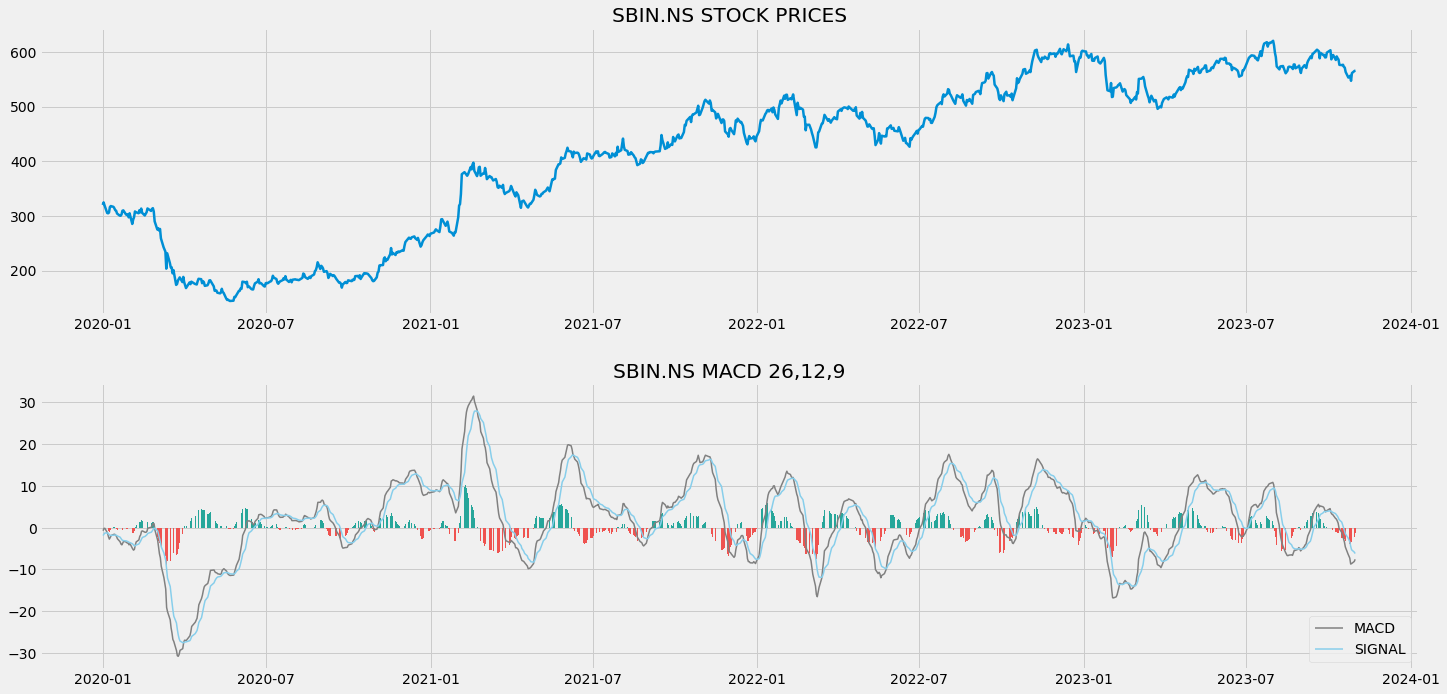

In [18]:
plot_data = df[df.index >= '2020-01-01']

def plot_macd(prices, macd, signal, hist):
    plt.figure(figsize=(22,11))
    ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)

    ax1.plot(prices, linewidth = 2.5)
    ax1.set_title('SBIN.NS STOCK PRICES')
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax2.set_title('SBIN.NS MACD 26,12,9')

    for i in range(len(prices)):
        if str(hist.iat[i])[0] == '-':
            ax2.bar(prices.index[i], hist.iat[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist.iat[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(plot_data['close'], plot_data['macd'], plot_data['macd_signal'], plot_data['macd_hist'])

In [19]:
def implement_stoch_macd_strategy(prices, k, d, macd, macd_signal):    
    buy_price = []
    sell_price = []
    stoch_macd_signal = []
    signal = 0

    for i in range(len(prices)):
        if k.iat[i] < 30 and d.iat[i] < 30 and macd.iat[i] < -2 and macd_signal.iat[i] < -2:
            if signal != 1:
                buy_price.append(prices.iat[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
                
        elif k.iat[i] > 70 and d.iat[i] > 70 and macd.iat[i] > 2 and macd_signal.iat[i] > 2:
            if signal != -1 and signal != 0:
                buy_price.append(np.nan)
                sell_price.append(prices.iat[i])
                signal = -1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
        
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_macd_signal.append(0)
            
    return buy_price, sell_price, stoch_macd_signal
            
buy_price, sell_price, stoch_macd_signal = implement_stoch_macd_strategy(df['close'], df['%k'], df['%d'], df['macd'], df['macd_signal'])

In [20]:
position = []
for i in range(len(stoch_macd_signal)):
    if stoch_macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if stoch_macd_signal[i] == 1:
        position[i] = 1
    elif stoch_macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = df['close']
k_line = df['%k']
d_line = df['%d']
macd_line = df['macd']
signal_line = df['macd_signal']
stoch_macd_signal = pd.DataFrame(stoch_macd_signal).rename(columns = {0:'stoch_macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_macd_position'}).set_index(df.index)

frames = [close_price, k_line, d_line, macd_line, signal_line, stoch_macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,%k,%d,macd,macd_signal,stoch_macd_signal,stoch_macd_position
Date,,,,,,,
2019-12-18,312.900543,46.389212,53.253755,-4.095247,-4.233469,0,1
2019-12-19,314.048981,55.054666,53.116934,-3.861860,-4.159147,0,1
2019-12-20,323.332153,81.557396,61.000425,-2.894459,-3.906210,0,1
2019-12-23,318.116364,66.666725,67.759596,-2.519613,-3.628890,0,1
2019-12-24,317.207184,64.071089,70.765070,-2.269744,-3.357061,0,1
...,...,...,...,...,...,...,...
2023-10-25,556.200012,10.844653,5.708166,-7.278439,-3.389519,0,1
2023-10-26,547.000000,6.816122,7.201392,-8.705621,-4.452739,0,1
2023-10-27,561.150024,33.364343,17.008372,-8.595797,-5.281351,0,1


In [21]:
df_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
stoch_macd_strategy_ret = []

for i in range(len(df_ret)):
    try:
        returns = df_ret['returns'].iat[i] * strategy['stoch_macd_position'].iat[i]
        stoch_macd_strategy_ret.append(returns)
    except:
        pass
    
stoch_macd_strategy_ret_df = pd.DataFrame(stoch_macd_strategy_ret).rename(columns = {0:'stoch_macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value / df['close'].iat[0])
stoch_macd_investment_ret = []

for i in range(len(stoch_macd_strategy_ret_df['stoch_macd_returns'])):
    returns = number_of_stocks * stoch_macd_strategy_ret_df['stoch_macd_returns'][i]
    stoch_macd_investment_ret.append(returns)

stoch_macd_investment_ret_df = pd.DataFrame(stoch_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(stoch_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)
print(cl('Profit gained from the STOCH MACD strategy by investing $100k in SBIN.NS : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the STOCH MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the STOCH MACD strategy by investing $100k in SBIN.NS : 45703.66
Profit percentage of the STOCH MACD strategy : 45%
